In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm

Parameters

In [ ]:
NUM_EPOCHS = 25
BATCH_SIZE = 64 
LEARNING_RATE = 0.00032
path_DS = 'raw-img'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Define transformations

In [47]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

Dataset

In [48]:
dataset = datasets.ImageFolder(root=path_DS, transform=transform)
num_classes = len(dataset.classes)
print(num_classes)

10


Split dataset

In [49]:
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size 
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

Data loaders

In [50]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


CNN 

In [ ]:
import torch
import torch.nn as nn

class OptimizedCNN(nn.Module):
    def __init__(self, num_classes):
        super(OptimizedCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.flatten_size = self._get_flatten_size()
        
        self.fc_layers = nn.Sequential(
            nn.Linear(self.flatten_size, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, num_classes)
        )

    def _get_flatten_size(self):
        with torch.no_grad():
            x = torch.randn(1, 3, 64, 64)
            x = self.conv_layers(x)
            return x.view(-1).size(0)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


Initialize model, loss, optimizer

In [65]:
model = OptimizedCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Training

In [66]:

def train_model():
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss, correct, total = 0, 0, 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        
        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch+1}: Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        scheduler.step()
    
    return train_losses, train_accs, val_losses, val_accs


In [67]:
train_losses, train_accs, val_losses, val_accs = train_model()

Epoch 1/25: 100%|██████████| 328/328 [01:46<00:00,  3.07it/s]


Epoch 1: Train Loss: 1.9894, Train Acc: 0.3198, Val Loss: 1.6073, Val Acc: 0.4498


Epoch 2/25: 100%|██████████| 328/328 [01:53<00:00,  2.88it/s]


Epoch 2: Train Loss: 1.5642, Train Acc: 0.4586, Val Loss: 1.5280, Val Acc: 0.4715


Epoch 3/25: 100%|██████████| 328/328 [01:47<00:00,  3.06it/s]


Epoch 3: Train Loss: 1.4109, Train Acc: 0.5147, Val Loss: 1.2831, Val Acc: 0.5667


Epoch 4/25: 100%|██████████| 328/328 [01:44<00:00,  3.15it/s]


Epoch 4: Train Loss: 1.3129, Train Acc: 0.5492, Val Loss: 1.2398, Val Acc: 0.5774


Epoch 5/25: 100%|██████████| 328/328 [01:43<00:00,  3.17it/s]


Epoch 5: Train Loss: 1.2262, Train Acc: 0.5774, Val Loss: 1.1834, Val Acc: 0.5957


Epoch 6/25: 100%|██████████| 328/328 [01:42<00:00,  3.20it/s]


Epoch 6: Train Loss: 1.1838, Train Acc: 0.5963, Val Loss: 1.1201, Val Acc: 0.6213


Epoch 7/25: 100%|██████████| 328/328 [01:44<00:00,  3.14it/s]


Epoch 7: Train Loss: 1.1424, Train Acc: 0.6093, Val Loss: 1.0610, Val Acc: 0.6374


Epoch 8/25: 100%|██████████| 328/328 [01:44<00:00,  3.13it/s]


Epoch 8: Train Loss: 1.0968, Train Acc: 0.6244, Val Loss: 1.2364, Val Acc: 0.5839


Epoch 9/25: 100%|██████████| 328/328 [01:44<00:00,  3.15it/s]


Epoch 9: Train Loss: 1.0644, Train Acc: 0.6368, Val Loss: 1.0561, Val Acc: 0.6450


Epoch 10/25: 100%|██████████| 328/328 [01:42<00:00,  3.19it/s]


Epoch 10: Train Loss: 1.0449, Train Acc: 0.6448, Val Loss: 1.0244, Val Acc: 0.6473


Epoch 11/25: 100%|██████████| 328/328 [01:42<00:00,  3.20it/s]


Epoch 11: Train Loss: 0.9374, Train Acc: 0.6785, Val Loss: 0.9005, Val Acc: 0.6958


Epoch 12/25: 100%|██████████| 328/328 [01:41<00:00,  3.22it/s]


Epoch 12: Train Loss: 0.9073, Train Acc: 0.6910, Val Loss: 0.8987, Val Acc: 0.6985


Epoch 13/25: 100%|██████████| 328/328 [01:41<00:00,  3.22it/s]


Epoch 13: Train Loss: 0.8993, Train Acc: 0.6946, Val Loss: 0.9027, Val Acc: 0.6867


Epoch 14/25: 100%|██████████| 328/328 [01:41<00:00,  3.23it/s]


Epoch 14: Train Loss: 0.8882, Train Acc: 0.6977, Val Loss: 0.8754, Val Acc: 0.6962


Epoch 15/25: 100%|██████████| 328/328 [01:42<00:00,  3.21it/s]


Epoch 15: Train Loss: 0.8813, Train Acc: 0.6997, Val Loss: 0.8820, Val Acc: 0.7004


Epoch 16/25: 100%|██████████| 328/328 [01:41<00:00,  3.23it/s]


Epoch 16: Train Loss: 0.8764, Train Acc: 0.7006, Val Loss: 0.8920, Val Acc: 0.7004


Epoch 17/25: 100%|██████████| 328/328 [01:44<00:00,  3.15it/s]


Epoch 17: Train Loss: 0.8733, Train Acc: 0.7022, Val Loss: 0.8780, Val Acc: 0.7027


Epoch 18/25: 100%|██████████| 328/328 [01:53<00:00,  2.89it/s]


Epoch 18: Train Loss: 0.8611, Train Acc: 0.7084, Val Loss: 0.8747, Val Acc: 0.6993


Epoch 19/25: 100%|██████████| 328/328 [01:42<00:00,  3.19it/s]


Epoch 19: Train Loss: 0.8621, Train Acc: 0.7063, Val Loss: 0.8694, Val Acc: 0.7084


Epoch 20/25: 100%|██████████| 328/328 [01:51<00:00,  2.95it/s]


Epoch 20: Train Loss: 0.8571, Train Acc: 0.7073, Val Loss: 0.8574, Val Acc: 0.6989


Epoch 21/25: 100%|██████████| 328/328 [01:55<00:00,  2.84it/s]


Epoch 21: Train Loss: 0.8416, Train Acc: 0.7122, Val Loss: 0.8439, Val Acc: 0.7042


Epoch 22/25: 100%|██████████| 328/328 [01:44<00:00,  3.14it/s]


Epoch 22: Train Loss: 0.8368, Train Acc: 0.7147, Val Loss: 0.8410, Val Acc: 0.7153


Epoch 23/25: 100%|██████████| 328/328 [01:43<00:00,  3.17it/s]


Epoch 23: Train Loss: 0.8418, Train Acc: 0.7156, Val Loss: 0.8452, Val Acc: 0.7157


Epoch 24/25: 100%|██████████| 328/328 [02:01<00:00,  2.69it/s]


Epoch 24: Train Loss: 0.8322, Train Acc: 0.7187, Val Loss: 0.8396, Val Acc: 0.7146


Epoch 25/25: 100%|██████████| 328/328 [01:45<00:00,  3.10it/s]


Epoch 25: Train Loss: 0.8426, Train Acc: 0.7131, Val Loss: 0.8518, Val Acc: 0.7107


# Results

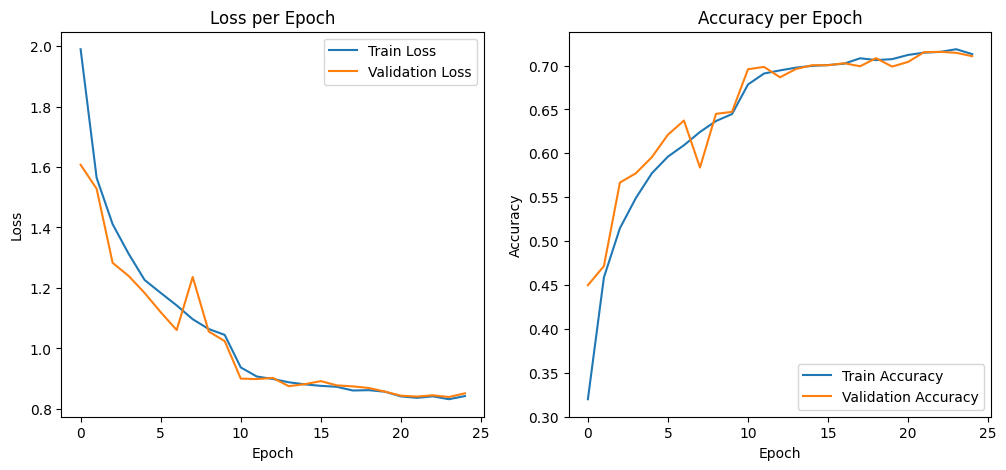

In [70]:
def plot_metrics():
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss per Epoch')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy per Epoch')
    
plot_metrics()

# Save model
torch.save(model.state_dict(), 'animal_classifierVER3.pth')

Базова версія, без гіперпараметрів і тюну

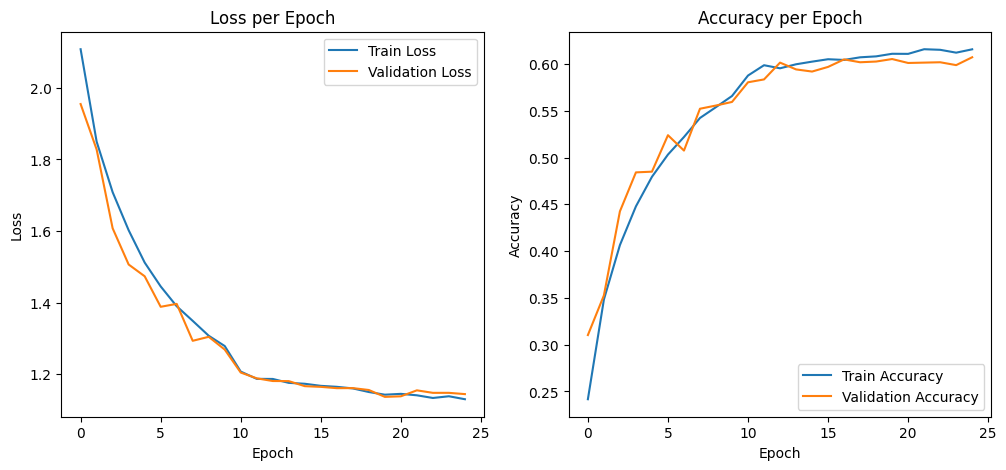